### 코드 참조
https://www.kaggle.com/code/baekseungyun/gpt-2-with-huggingface-pytorch


In [2]:
path = "/content/drive/MyDrive/Colab_Notebooks/Huggingface"

In [4]:
import pandas as pd

dftrain = pd.read_csv(path+"/data/ag_news/train.csv")
dftrain = dftrain.drop(columns='Unnamed: 0')
dftrain

,text,label
0,Lycos Antispam Screensaver Draws Fire Screensa...,3
1,Likely many of this rank could soon be filing ...,1
2,Weekend warriors in test of technique and temp...,1
3,Wall St. Seen Sliding After Jobless Data NEW ...,2
4,Kodak plight a snapshot of UK work The digital...,2
...,...,...
19995,"Arsenal win thriller, equal Notts record LONDO...",1
19996,Retailers and Their September Sales (AP) AP - ...,2
19997,"Stocks Hit by Oil, Bonds Up on Weak Jobs NEW ...",2
19998,Bush selects Kellogg executive to head Commerc...,2


<Axes: xlabel='label'>

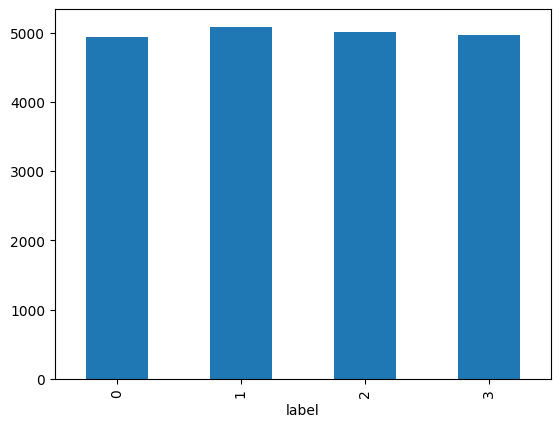

In [6]:
dftrainplot=dftrain.groupby(['label']).size()
dftrainplot.plot(kind='bar')

In [52]:
dftest = pd.read_csv(path+"/data/ag_news/test.csv")
dftest = dftest.drop(columns='Unnamed: 0')
dftest

,text,label
0,Calif. Mental Health Services May Expand (AP) ...,0
1,Radcliffe withdrawal not due to injury World r...,1
2,IBM posts broad Q3 revenue growth NEW YORK - I...,3
3,Viagra bought online 'often fake' Half of Viag...,3
4,Ford to Repair Faulty Heated Seats in Focus Ca...,2
...,...,...
2995,A threat to the West Bank pullout The expected...,0
2996,Pompey start life without Harry with a win Lon...,1
2997,Ellison: Censorship ain't my problem When it c...,3
2998,Glazer stake in Man Utd nears 30 US tycoon Mal...,0


<Axes: xlabel='label'>

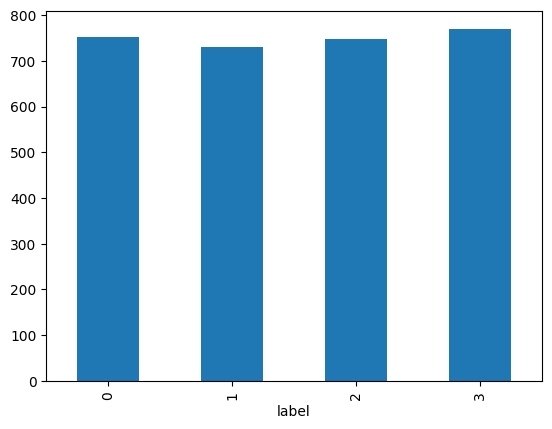

In [8]:
dftestplot=dftest.groupby(['label']).size()
dftestplot.plot(kind='bar')

<Axes: xlabel='label'>

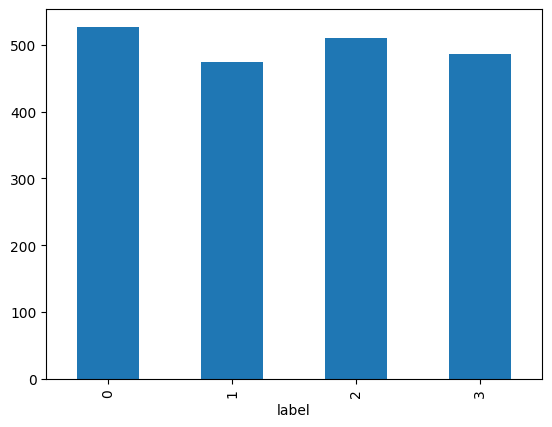

In [9]:
dfval = pd.read_csv(path+"/data/ag_news/validation.csv")
dfval = dfval.drop(columns='Unnamed: 0')
dfval=dfval.groupby(['label']).size()
dfval.plot(kind='bar')

In [ ]:
# val이 이미 나눠져있으므로 필요없음.
# from sklearn.model_selection import train_test_split
# train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.2)

## Tokenizer

new

In [10]:
!pip install torchsampler transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 90.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.4/269.4 kB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 10.0 MB/s eta 0:00:00


In [15]:
import transformers
from datasets import load_dataset
import torch
from datasets import load_dataset
from transformers import AutoTokenizer
from torchsampler import ImbalancedDatasetSampler
from torch.utils.data import DataLoader
from transformers import AutoModel, AdamW

from transformers import set_seed, GPT2Config, GPT2Tokenizer, GPT2ForSequenceClassification


# Model and Tokenizer

In [12]:
from datasets import load_dataset
import pandas as pd

In [17]:
set_seed(731) # random

model_config = GPT2Config.from_pretrained('gpt2', num_labels=4)
model = GPT2ForSequenceClassification.from_pretrained('gpt2', config=model_config)

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left" # Very Important
tokenizer.pad_token = tokenizer.eos_token

model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 2. Build Dataset

In [59]:
import pandas as pd
from torch.utils.data import Dataset

class AGNewsDataset(Dataset):
  def __init__(self, train=True):
    super().__init__()
    self.train = train
    self.data = dftrain if train else dftest

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    record = self.data.iloc[index]
    text = record['text']
    if self.train:
      return {'text':text, 'label':record['label']}
    else:
      return {'text':text, 'label':'0'}

train_dataset = AGNewsDataset(train=True)
test_dataset = AGNewsDataset(train=False)
val_da

In [28]:
for i in range(10):
  print(train_dataset.__getitem__(i)['text'])

Lycos Antispam Screensaver Draws Fire Screensaver offers to "spam the spammers," but not everyone is pleased with its message.
Likely many of this rank could soon be filing The championship euphoria has hardly abated. However it's never too early to start thinking about free agency. Not so much who's coming, but which Red Sox may not be around to bask in the Fenway love when the 2004 World Series flag is raised in April.
Weekend warriors in test of technique and temperament THE breeze barely tickled the flags around the first tee, the weather was warming and the air light. The greens were true and gave good grip to approaches.
Wall St. Seen Sliding After Jobless Data  NEW YORK (Reuters) - U.S. stock futures pointed to a  slightly lower open on Wall Street  on Thursday after a report  showed a larger-than-expected rise in claims for unemployment  benefits, a gauge of strength in the jobs market.
Kodak plight a snapshot of UK work The digital revolution #39;s two-way impact on British jo

## 3. Data Collator

In [33]:
class Gpt2ClassificationCollator(object):
  def __init__(self, tokenizer, max_seq_len=None):
    self.tokenizer = tokenizer
    self.max_seq_len = max_seq_len

    return

  def __call__(self, sequences):
    texts = [sequence['text'] for sequence in sequences]
    labels = [int(sequence['label']) for sequence in sequences]
    inputs = self.tokenizer(text=texts,
                            return_tensors='pt',
                            padding=True,
                            truncation=True,
                            max_length=self.max_seq_len)
    inputs.update({'labels': torch.tensor(labels)})
    return inputs

gpt2classificationcollator = Gpt2ClassificationCollator(tokenizer=tokenizer, max_seq_len=60)

## 4. DataLoader

In [62]:
from torch.utils.data import DataLoader, random_split

train_size = int(len(train_dataset)*0.8)
val_size = len(train_dataset)-train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=32,
                              shuffle=True,
                              collate_fn = gpt2classificationcollator)
val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=32,
                            shuffle=False,
                            collate_fn=gpt2classificationcollator)
test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=32,
                             shuffle=False,
                             collate_fn=gpt2classificationcollator)

## 5. Optimizer & Lr Scheduler

In [66]:
from transformers import AdamW, get_cosine_schedule_with_warmup

total_epochs =500

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias','LayerNorm.weight']
optimizer_grouped_parameters=[
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay': 0.01},
     {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay':0.0}
]
optimizer = AdamW(optimizer_grouped_parameters,
                  lr=1e-5,
                  eps=1e-8)

num_train_steps = len(train_dataloader)*total_epochs
num_warmup_steps = int(num_train_steps * 0.1)

lr_scheduler = get_cosine_schedule_with_warmup(optimizer,
                                               num_warmup_steps=num_warmup_steps,
                                               num_training_steps=num_train_steps)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## 6. Train & Validation

In [46]:
import torch

def train(dataloader, optimizer, scheduler, device_):
  global model
  model.train()

  prediction_labels = []
  true_labels = []

  total_loss = []

  for batch in dataloader :
    true_labels += batch['labels'].numpy().flatten().tolist()
    batch = {k:v.type(torch.long).to(device_) for k, v in batch.items()}

    outputs = model(**batch)
    loss,logits = outputs[:2]
    logits = logits.detach().cpu().numpy()
    total_loss.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # prevent exploding gradient
    
    optimizer.step()
    scheduler.step()

    prediction_labels += logits.argmax(axis=-1).flatten().tolist()

    return true_labels, prediction_labels, total_loss

    # f1 추가해야함

In [40]:
def validation(dataloader,device_):
  global model
  model.eval()

  prediction_labels = []
  true_labels = []
  total_loss = []

  for batch in dataloader:
        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device_) for k, v in batch.items()}
        
        with torch.no_grad():
            outputs = model(**batch)
            loss, logits = outputs[:2]
            logits = logits.detach().cpu().numpy()
            total_loss.append(loss.item())

            prediction_labels += logits.argmax(axis=-1).flatten().tolist()
        
  return true_labels, prediction_labels, total_loss
# f1 추가해야함

## 7. Run

In [67]:
from sklearn.metrics import classification_report, accuracy_score
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

all_loss = {'train_loss': [], 'val_loss': []}
all_acc = {'train_acc': [], 'val_acc': []}

for epoch in range(total_epochs):
  y, y_pred,train_loss = train(train_dataloader,optimizer, lr_scheduler,device)
  train_acc = accuracy_score(y, y_pred)

  y, y_pred, val_loss = validation(val_dataloader, device)
  val_acc = accuracy_score(y, y_pred)

  all_loss['train_loss'] += train_loss
  all_loss['val_loss']+= val_loss

  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

  print(f'Epoch: {epoch}, train_loss: {torch.tensor(train_loss).mean():.3f}, train_acc:{train_acc:.3f}, val_loss: {torch.tensor(val_loss).mean():.3f}, val_acc: {val_acc:.3f}')


Epoch: 0, train_loss: 2.127, train_acc:0.250, val_loss: 2.363, val_acc: 0.263
Epoch: 1, train_loss: 2.103, train_acc:0.219, val_loss: 2.363, val_acc: 0.263
Epoch: 2, train_loss: 2.829, train_acc:0.156, val_loss: 2.363, val_acc: 0.263
Epoch: 3, train_loss: 2.507, train_acc:0.312, val_loss: 2.363, val_acc: 0.263
Epoch: 4, train_loss: 2.362, train_acc:0.156, val_loss: 2.363, val_acc: 0.263
Epoch: 5, train_loss: 2.408, train_acc:0.219, val_loss: 2.363, val_acc: 0.263
Epoch: 6, train_loss: 2.294, train_acc:0.250, val_loss: 2.363, val_acc: 0.263
Epoch: 7, train_loss: 2.001, train_acc:0.375, val_loss: 2.363, val_acc: 0.263
Epoch: 8, train_loss: 2.449, train_acc:0.219, val_loss: 2.363, val_acc: 0.263
Epoch: 9, train_loss: 2.313, train_acc:0.250, val_loss: 2.363, val_acc: 0.263
Epoch: 10, train_loss: 2.408, train_acc:0.281, val_loss: 2.363, val_acc: 0.263
Epoch: 11, train_loss: 1.894, train_acc:0.344, val_loss: 2.363, val_acc: 0.263
Epoch: 12, train_loss: 2.073, train_acc:0.250, val_loss: 2.363

KeyboardInterrupt: ignored

## 7.1. Check Loss with Graph

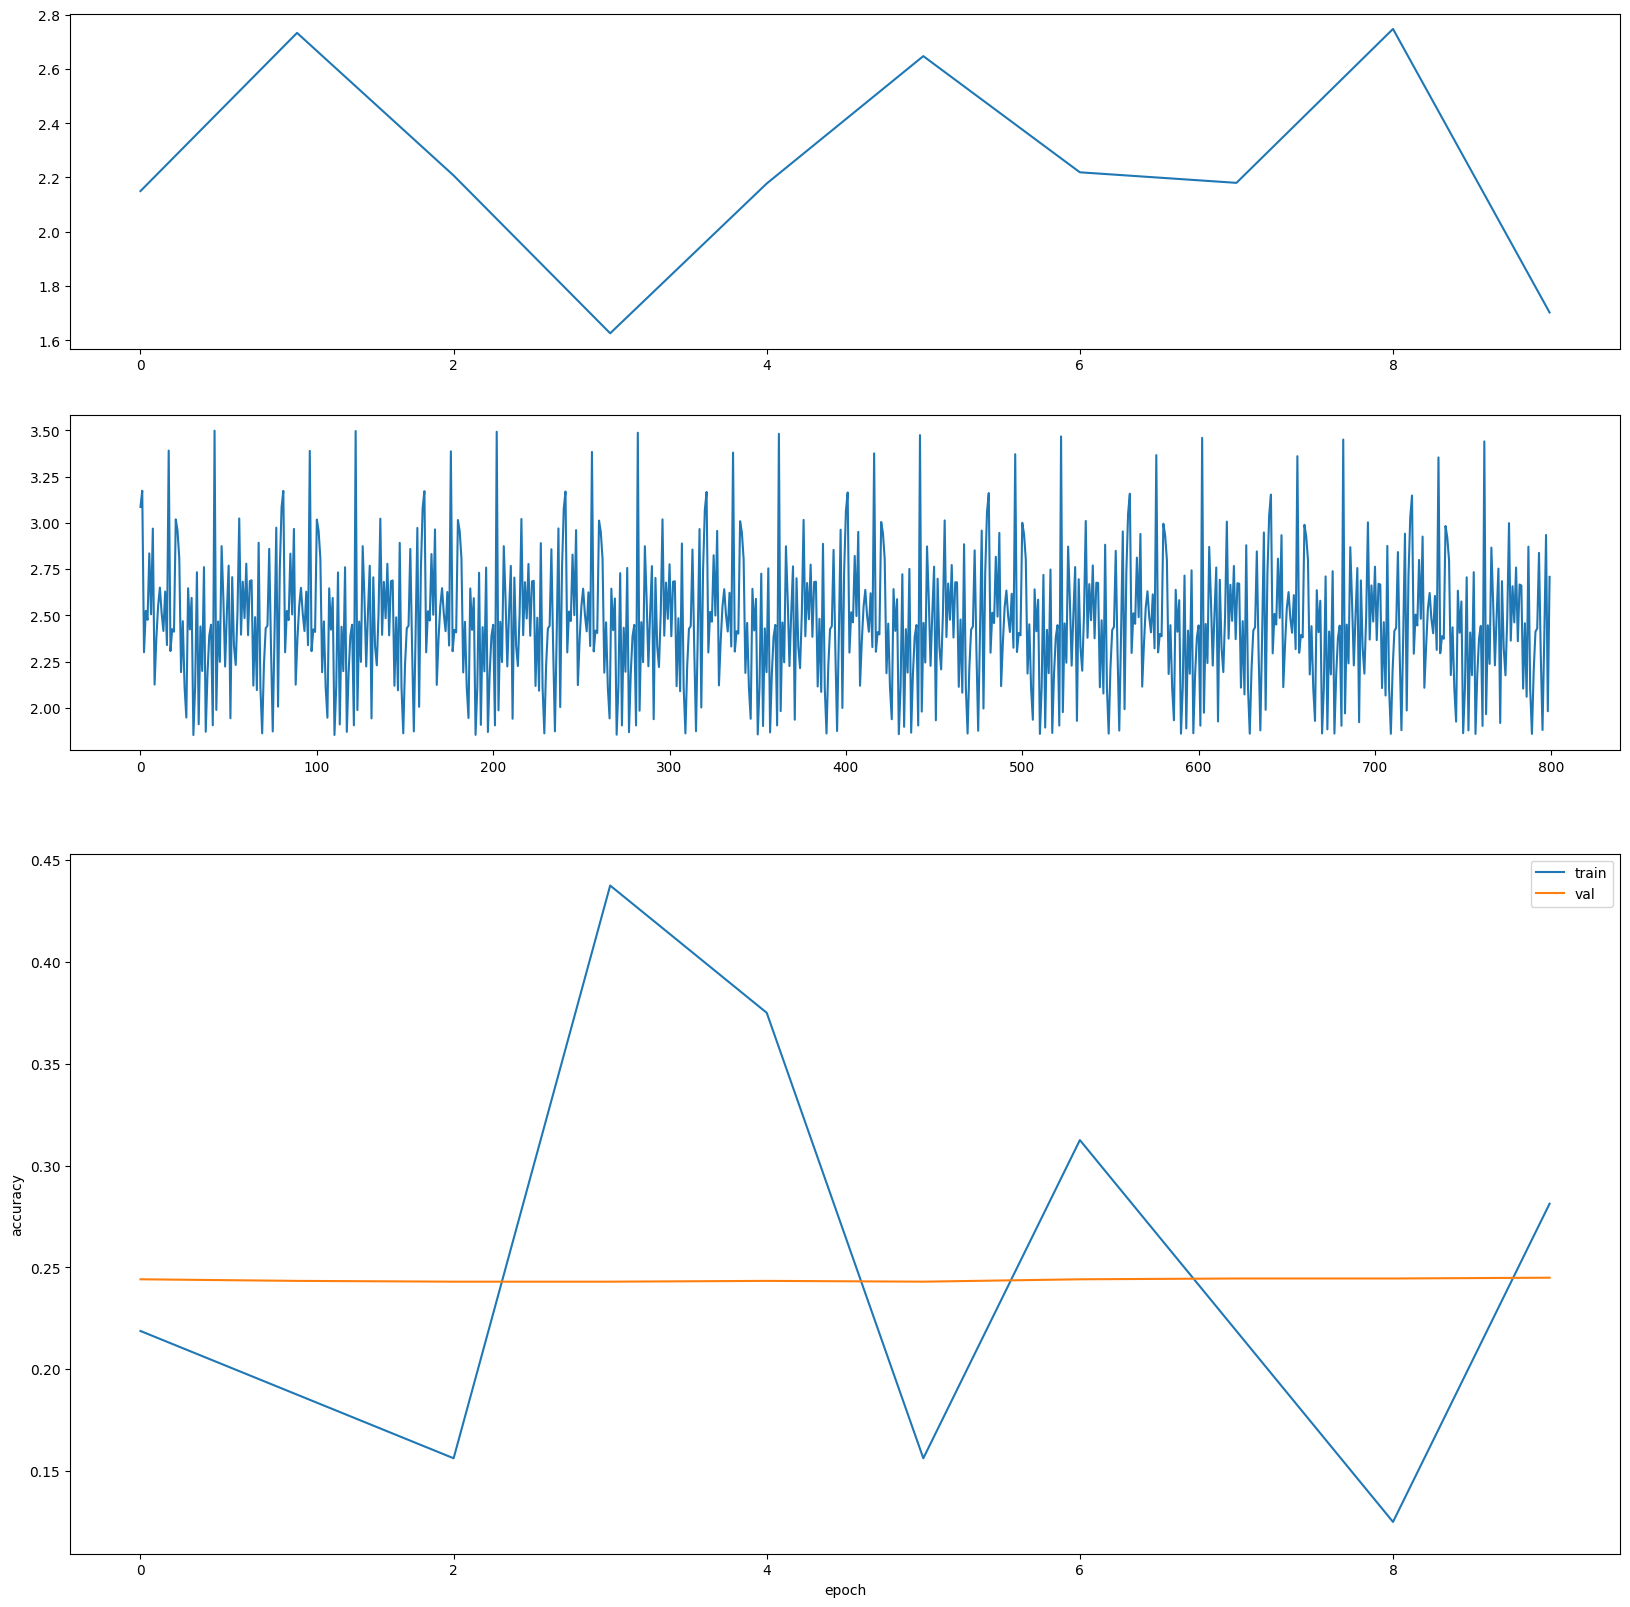

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig = plt.figure(figsize=(20, 20))
a = fig.add_subplot(4, 1, 1)
b = fig.add_subplot(4, 1, 2)
c = fig.add_subplot(2, 1, 2)
a.plot(all_loss['train_loss'])
b.plot(all_loss['val_loss'])
c.plot(all_acc['train_acc'])
c.plot(all_acc['val_acc'])
c.set(xlabel='epoch', ylabel='accuracy')
c.legend(['train', 'val'])

pass

## 8. Run on Test Data

In [65]:
_, y_pred, _ = validation(test_dataloader, device)

dftest1 = pd.read_csv(path+"/data/ag_news/test.csv")
dftest1['target']=y_pred
dftest1.to_csv('testresults.csv',index=False)